# Image Denoising using TomoGANs
## Generative Adversarial Networks:
Generative adversarial networks (GANs) provide great results in denoising images by taking advantage of deep learning techniques. Their architecture consists of a generator and a discriminator.  The generator produces a sample, and the discriminator decides whether this is generated or taken from the real sample using a binary classification method using a sigmoid function. First, the discriminator is trained with pure real data and pure fake data, so it will learn whether a sample is real or fake. Then the generator is switched on and is used to produce fake samples. After that, the discriminator is trained to learn that the generated data is fake data. Finally, the generator is trained to learn from the discriminator’s predictions to fool the discriminator. Since these two systems compete against each other, the whole system is aptly named “adversarial networks”. Specifically, the discriminator, providing adversarial loss, is a helper for training the generator to generate better perceptual quality images. One challenge of these networks is that the generator and the discriminator should be in balance. If one overpowers the other, the network doesn’t work. Also, when they are applied on high-resolution images, like in medical imaging, they produce non-existent artifacts in the images.

## TomoGANs:
To overcome these problems, a better model called TOMOGANs were recently developed. These adapt the U-network architecture which makes them a better candidate for high-resolution images. The generator is used to enhance images and the discriminator is used as a helper to train the generator. Differing from classic GANs, which generate samples from random noise inputs, TOMOGANs create samples from closely related noisy inputs. In general, TOMOGANs provide visible improvement to images reconstructed from noisy projection datasets. Once they are trained on one sample, they can be effectively applied to other samples even if they exhibit different noise characteristics.  

We will apply pre-trained TomoGAN on three images to denoise them:


In [11]:
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, glob, os, shutil

In [12]:
# overwrite anyway 
if os.path.isdir('model'): 
    shutil.rmtree('model')
os.mkdir('model') # to save temp output

!wget -O model/TomoGAN.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5

--2023-02-15 00:10:16--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/model/TomoGAN.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2854872 (2.7M) [application/octet-stream]
Saving to: ‘model/TomoGAN.h5’

model/TomoGAN.h5    100%[===================>]   2.72M  --.-KB/s    in 0.07s   

2023-02-15 00:10:17 (40.2 MB/s) - ‘model/TomoGAN.h5’ saved [2854872/2854872]



In [13]:
TomoGAN_mdl = tf.keras.models.load_model('model/TomoGAN.h5', )
TomoGAN_mdl.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   16          ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2336        ['conv2d[0][0]']                 
                                32)                                                           

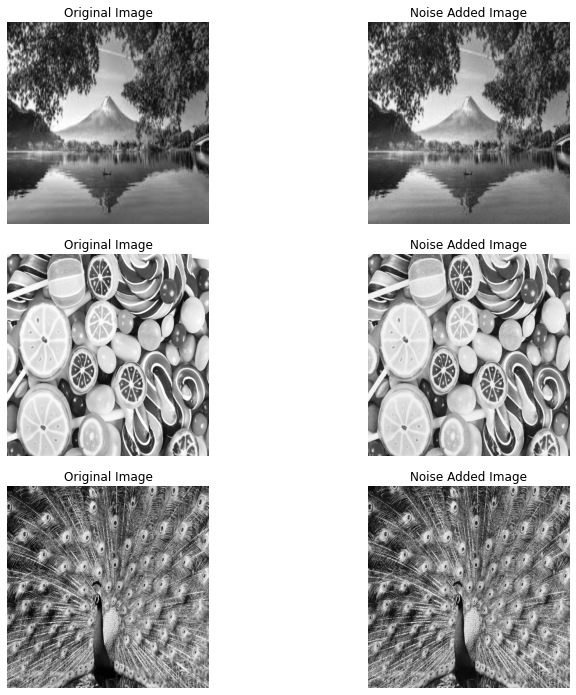

In [62]:
import skimage.io
import matplotlib.pyplot as plt
import skimage.filters
from skimage.util import random_noise 
from skimage.transform import resize
#Adding noise to an image:
bacteria = skimage.io.imread('land.jpg',as_gray=True)
bacteria = resize(bacteria[:,:], (2048,2048))
candy = skimage.io.imread('candy.jpg',as_gray=True)
candy = resize(candy[:,:], (2048, 2048))
peacock = skimage.io.imread('peacock.jpg',as_gray=True)
peacock = resize(peacock[:,:], (2048, 2048))
#Add Gaussian noise:
noised_bacteria = random_noise(bacteria, mode='gaussian')
noised_candy = random_noise(candy, mode='gaussian')
noised_peacock = random_noise(peacock, mode='gaussian')
bacteria = np.round(bacteria*255)
candy = np.round(candy*255)
peacock = np.round(peacock*255)
noised_bacteria = np.round(noised_bacteria*255)
noised_candy = np.round(noised_candy*255)
noised_peacock = np.round(noised_peacock*255)
#Plot all noised images with the original image:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(12,10), sharex=True, sharey=True, squeeze=True)
ax = ax.ravel()
ax[0].imshow(bacteria, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(noised_bacteria, cmap='gray')
ax[1].set_title('Noise Added Image')
ax[2].imshow(candy, cmap='gray')
ax[2].set_title('Original Image')
ax[3].imshow(noised_candy, cmap='gray')
ax[3].set_title('Noise Added Image')
ax[4].imshow(peacock,cmap='gray')
ax[4].set_title('Original Image')
ax[5].imshow(noised_peacock, cmap='gray')
ax[5].set_title('Noise Added Image')
fig.tight_layout()
for a in ax:
    a.axis('off')

In [63]:
noised = np.array([noised_bacteria, noised_candy, noised_peacock])
gt = np.array([bacteria, candy, peacock])

## Results:

1/1 [==============================] - 25s 25s/step
(2048, 2048)


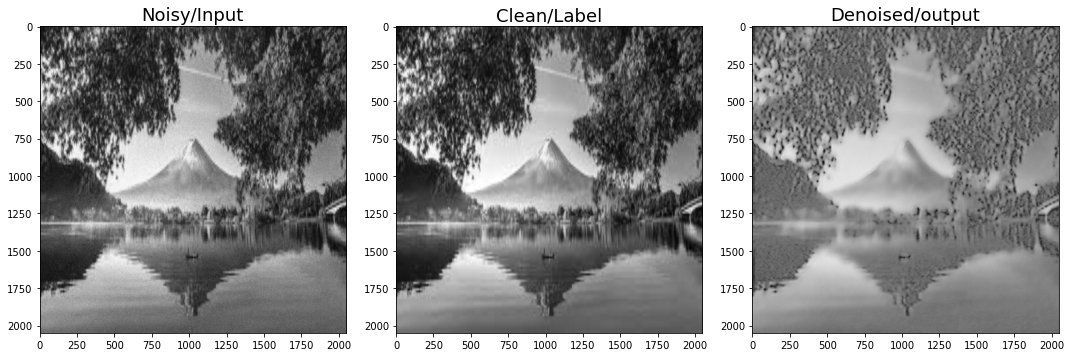

1/1 [==============================] - 21s 21s/step
(2048, 2048)


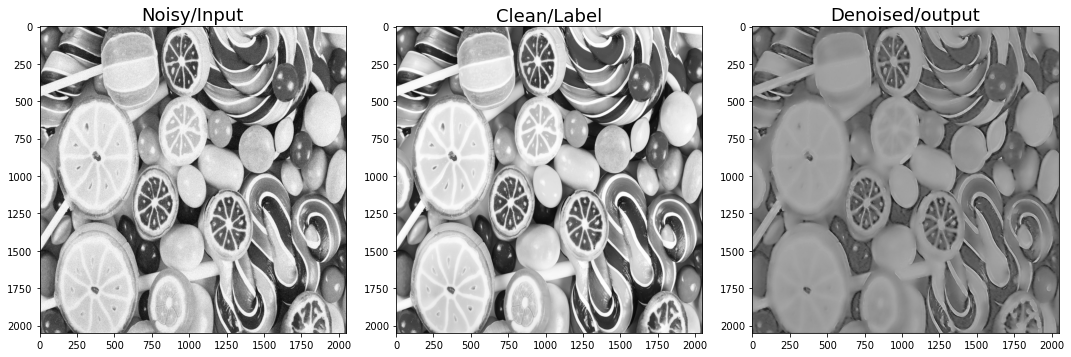

1/1 [==============================] - 23s 23s/step
(2048, 2048)


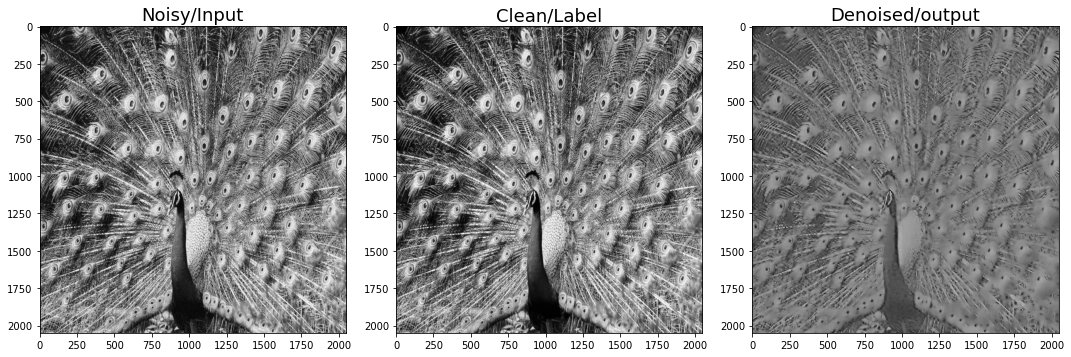

In [64]:
for _idx in range(noised.shape[0]):
    # just one line of code to denoise, need to remember that the input is four dimension [n, h, w, c] 
    dn_img = TomoGAN_mdl.predict(noised[_idx:_idx+1,:,:,np.newaxis]).squeeze()
    print(dn_img.shape)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(noised[_idx], cmap='gray')
    plt.title('Noisy/Input', fontsize=18)
    plt.subplot(132)
    plt.imshow(gt[_idx], cmap='gray')
    plt.title('Clean/Label', fontsize=18)
    plt.subplot(133)
    plt.imshow(dn_img, cmap='gray')
    plt.title('Denoised/output', fontsize=18)
    plt.tight_layout(); plt.show(); plt.close()

### Analysis:
When the TomoGAN is applied to images with size of 1024 and above, they provide great results. By taking advantage of two systems running against each other, they obtain  even better results than CNNs. Especially with the peacock image, result was much better than CNN result which can be seen below:

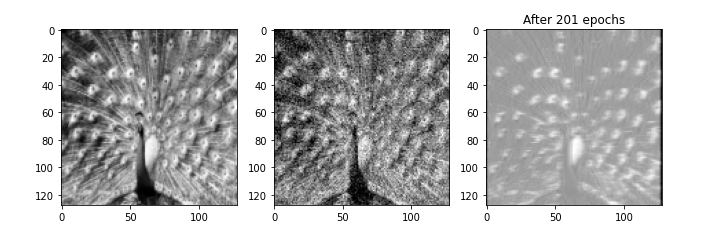


Reference:


Peacock image: https://images.pexels.com/photos/638738/pexels-photo-638738.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1

Land image: https://helpx.adobe.com/photoshop/using/convert-color-image-black-white.html

Candy image: https://www.simplemost.com/wp-content/uploads/2015/09/candy.jpg